<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

### how many missing values per column

In [ ]:
df = pd.read_csv("../data/titantic.csv", index_col=0)
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [ ]:
def is_na(df): return df.isna()
def is_ya(df): return df.isna() == False
def sum_cols(df): return df.sum()
def sum_rows(df): return df.sum(axis=1)
def value_counts(s): return s.value_counts(sort=False).sort_index()

sum_cols(is_na(df))

pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

Q: What does ```df.isna().sum(axis=1)``` mean when ```axis``` is set to 0 or 1 ?

A: 
- 0=columns(default)
- 1=rows

my simple composable functions barely save us any space, though they are significantly 

In [ ]:
row_counts = compose(is_na, sum_rows, value_counts)(df)
row_counts = df.isna().sum(axis=1).value_counts(sort=False).sort_index()

row_counts

1    186
2    290
3    399
4    278
5    156
dtype: int64

In [ ]:
# col_counts = counts(na_in_cols(df))

col_counts = compose(is_na, sum_cols, value_counts)(df)

col_counts

0       6
1       1
2       1
263     1
564     1
823     1
1014    1
1188    1
dtype: int64

### how many rows have multiple missing values

In [ ]:
compose(is_na, sum_cols, value_counts)(df)

0       6
1       1
2       1
263     1
564     1
823     1
1014    1
1188    1
dtype: int64

In [ ]:
def counts_to_cdf(count_df): return count_df.cumsum() / sum(count_df)

row_cdf = counts_to_cdf(row_counts)
row_cdf

1    0.142093
2    0.363636
3    0.668449
4    0.880825
5    1.000000
dtype: float64

In [ ]:
counts_to_cdf(col_counts)

0       0.461538
1       0.538462
2       0.615385
263     0.692308
564     0.769231
823     0.846154
1014    0.923077
1188    1.000000
dtype: float64

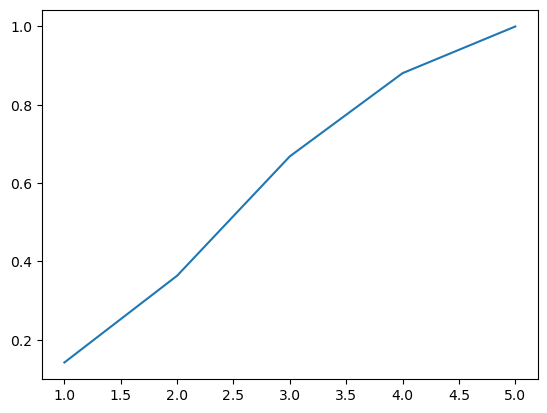

In [ ]:
def plot_cdf(cdf):
    fig, ax = plt.subplots()
    sns.lineplot(ax=ax, data=cdf)
plot_cdf(row_cdf)
plt.show()

### Concepts

What relationships do the different columns have to each other?

- Deterministic: every row follows this rule.
- Statistical: these rules tend to be followed in general.

Types of relationships:
- column block: an exact match for where nans occur
- anticorrolated: when one is missing, the other is not.
- potential dependency: missing values of B only occur if there's a missing value of A.

Maybe it's better to 

In [ ]:
def conditional_nan_p(df):
    cols = df.columns
    dats = {}
    ndf = df.isna()
    interesting_cols = []
    for col in cols:
        nans_index = ndf[col]
        n_nans = sum(nans_index)
        if n_nans == 0:
            row = pd.Series(0, index=cols)
        else:
            row = ndf.loc[nans_index].sum() / n_nans
            interesting_cols.append(col)
        dats[col] = row
    print(interesting_cols)
    cor = pd.DataFrame(dats)
    ones = pd.DataFrame(np.ones(cor.shape), index=cor.index, columns=cor.columns)
    return cor.loc[interesting_cols, interesting_cols]

cor = conditional_nan_p(df)
cor

['age', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']


,age,fare,cabin,embarked,boat,body,home.dest
age,1.000000,0.0,0.236686,0.0,0.235723,0.220539,0.359929
fare,0.000000,1.0,0.000986,0.0,0.001215,0.000000,0.001773
cabin,0.912548,1.0,1.000000,0.0,0.876063,0.778620,0.934397
embarked,0.000000,0.0,0.000000,1.0,0.000000,0.001684,0.001773
boat,0.737643,1.0,0.711045,0.0,1.000000,0.590909,0.742908
body,0.996198,0.0,0.912229,1.0,0.852977,1.000000,0.914894
home.dest,0.771863,1.0,0.519724,0.5,0.509113,0.434343,1.000000
